In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob

plt.style.use('science')

In [2]:

orbital_period = 51.4167

spectra_dir = 'data/Spectra/SONG/'

In [3]:
def get_spectra(epoch, order, return_header=False):
    spectra = sorted(glob.glob(spectra_dir + '*.fits'))
    spectrum = spectra[epoch]
    wav, flux, flux_err = [], [], []
    spectra_data = pf.getdata( spectrum ) # Get the data
    spectra_hdr = pf.getheader( spectrum ) # Get the full header
    if return_header:
        return spectra_data[3,order,:], spectra_data[0,order,:] / spectra_data[2,order,:], spectra_hdr
    return spectra_data[3,order,:], spectra_data[0,order,:] / spectra_data[2,order,:]

In [4]:
from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def interpolate_spectrum(x, y, oversample=5):
    f1  = interpolate.interp1d(x, y, kind = 'cubic')
    df = x[1] - x[0]
    int_wav = np.arange(x[0], x[-1], df / oversample)
    int_flux = f1(int_wav)
    return int_wav, int_flux

def smooth_spectrum(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten_spectrum(x, y, k=3, s=10):
    spl = UnivariateSpline(x, y, k=k, s=s)
    return y / spl(x)

def resolve_spectrum(x, y):
    # Interpolate
    wav, flux = interpolate_spectrum(x,y)
    # Smooth
    flux = smooth_spectrum(wav, flux)
    # Flatten
    flux = flatten_spectrum(wav, flux)
    
    return wav, flux

In [5]:
order = 16
epochs = len(glob.glob(spectra_dir + '*.fits'))
obs_times = []
for epoch in range(epochs):
    wav, flux, hdr = get_spectra(epoch,order, return_header=True)
    obs_times.append(hdr['BJD-MID'] + 2400000)

In [6]:
len(obs_times)

61

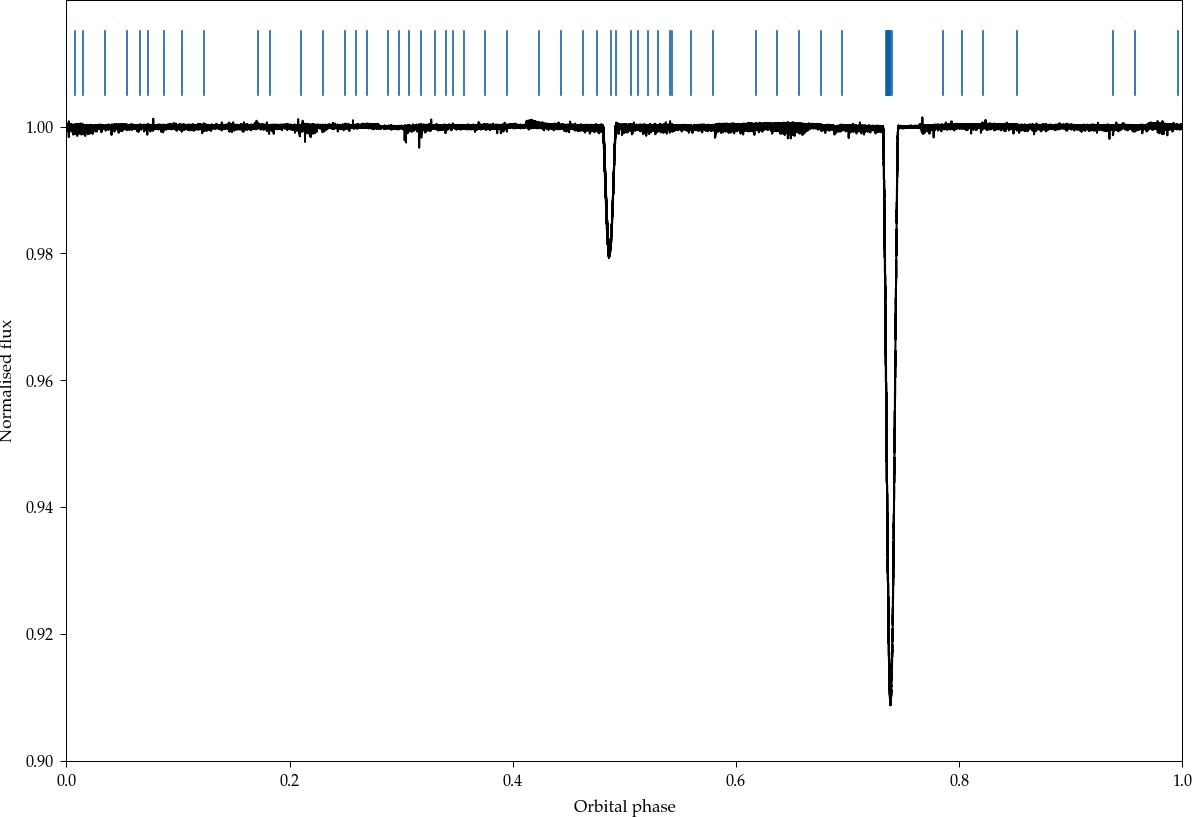

In [7]:
# plt.figure(figsize=[mnras_size(550.11743)[0], 1.8])
plt.figure(figsize=[10,7])
t, y, yerr = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T
tjd_0 = 2457000
t += tjd_0

porb = 51.4213
t0 = 1696.0194

fold = t % porb / porb
sort = np.argsort(fold)
plt.plot(fold[sort],y[sort], c='k')

for obs in obs_times:
    plt.plot([(obs % porb / porb), (obs % porb / porb)], [1.015, 1.005], linewidth=0.8, alpha=1., c='C0')

plt.xlim(0,1)
plt.ylim(0.91, 1.02)
plt.xlabel('Orbital phase')
plt.ylabel('Normalised flux')
plt.yticks(np.array([0.9 , 0.92, 0.94, 0.96, 0.98, 1.]));
# plt.xlim(0.73, 0.745)
# plt.savefig(overleaf_path + 'lc_with_spectra.pdf', dpi=300, bbox_inches='tight', pad_inches=0.)

In [8]:
np.array(obs_times) % porb / porb

array([0.4751446 , 0.5426028 , 0.85173683, 0.00785697, 0.06607292,
       0.08714013, 0.10399508, 0.12324788, 0.18262125, 0.25964186,
       0.2984782 , 0.3173372 , 0.34008679, 0.35587488, 0.3755134 ,
       0.39484093, 0.49240816, 0.51221252, 0.53033945, 0.78583652,
       0.80225867, 0.82122411, 0.93820389, 0.95713201, 0.99585997,
       0.01527049, 0.03459695, 0.05445753, 0.07336846, 0.1715498 ,
       0.21049657, 0.22988002, 0.24934739, 0.26922675, 0.28793553,
       0.3073753 , 0.33054179, 0.34631201, 0.42375327, 0.44316448,
       0.46252204, 0.48775476, 0.50634702, 0.52124396, 0.54077572,
       0.55974819, 0.57945757, 0.61788468, 0.63703197, 0.65671601,
       0.67592132, 0.69543882, 0.73403063, 0.73492962, 0.73577096,
       0.73634604, 0.73691527, 0.73740662, 0.73802846, 0.73841494,
       0.74018567])

In [9]:
from scipy.optimize import minimize

def model(theta, x):
    a, c, d, x0 = theta
    gaussian = a*np.exp(-(x-x0)**2/(2*d**2)) + 0#c
    return gaussian

def func(theta, x, y):
    gaussian = model(theta, x)
    return 0.5*np.sum((y-gaussian)**2)#/sigma2 + np.log(sigma2))

def fit_gaussian(x, y, x0):
    res = minimize(func, x0, args=(x, y))
    return res

100%|██████████| 61/61 [00:16<00:00,  3.79it/s]


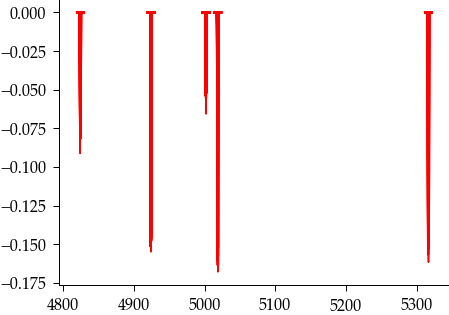

In [10]:
import tqdm
times = []
fwhms = []
wav_shifts = []
bvcs = []
    
lines = np.array([4824.13, # Fe-II
                  4923.93, # Fe
                  #4957.3,
                  5018.44, # Fe-II
                  5001.86, # Fe-I
#                   5056.32, 
#                   5100.66, 
                  5316.61  # Fe-II
                 ])

for epoch in tqdm.tqdm(range(epochs)):
    # FOR EVERY EPOCH
    wav, flux, hdr = get_spectra(epoch, 5, return_header=True)
    times.append(hdr['BJD-MID'])
    bvcs.append(hdr['BVC'])
    flat_waves = []
    flat_fluxes = []
    for order in [9,10,11,12,13,15,16,17,18,19, 20,21,22,23,24,25]:
        fwhm = []
        wav_shift = []
        # AND FOR EVERY ORDER.. 
        wav, flux, hdr = get_spectra(epoch, order, return_header=True)
        interp_wav, interp_flux = interpolate_spectrum(wav, flux)
        smooth_flux = smooth_spectrum(interp_wav, interp_flux, factor=0.05)
        
        flat_waves.extend(interp_wav)
        flat_fluxes.extend(flatten_spectrum(interp_wav, smooth_flux, s=10, k=5))
        
    flat_waves, flat_fluxes = np.array(flat_waves), np.array(flat_fluxes)
    fwhm = []
    wav_shift = []
    sigma = []
    for line in lines:
        # Fit each line profile
        x0 = [-0.15,0,1,line]
        mask = (flat_waves > (line - 5)) & (flat_waves < (line + 5))
        res = fit_gaussian(flat_waves[mask], (flat_fluxes - 1.)[mask], x0)
        plt.plot(flat_waves[mask], model(res['x'], flat_waves[mask]), c='red', linewidth=0.8)
        
        fwhm.extend([res.x[-2]])
#         sigma.extend([res.x[-2]])
        wav_shift.extend([res.x[-1]])
    fwhms.append(fwhm)
    wav_shifts.append(wav_shift)
fwhms, wav_shifts = np.array(fwhms), np.array(wav_shifts)

In [11]:
x0

[-0.15, 0, 1, 5316.61]

In [25]:
test = ((wav_shifts - lines[None,:])) + np.array(bvcs)[:,None] / 299792.458
np.median(test, axis=1)

array([-0.0915913 ,  0.26033683, -0.70038709, -0.89535692, -0.86997843,
       -0.87075478, -0.85851908, -0.85506095, -0.80112998, -0.70679285,
       -0.64066379, -0.60620508, -0.55608518, -0.5216322 , -0.47436319,
       -0.41779333, -0.03116966,  0.07333483,  0.18058427, -0.38657061,
       -0.47358921, -0.5508825 , -0.79386422, -0.80052327, -0.81174071,
       -0.82330738, -0.81752276, -0.82187655, -0.80853981, -0.73807956,
       -0.68639732, -0.65227823, -0.62923657, -0.59946752, -0.56398004,
       -0.51981331, -0.475165  , -0.43736705, -0.20198662, -0.14237736,
       -0.05088621,  0.06847369,  0.17048313,  0.25504151,  0.37591421,
        0.50627662,  0.64576925,  0.84853629,  0.89659549,  0.84427746,
        0.71600074,  0.5307709 ,  0.16787024,  0.1628877 ,  0.15926703,
        0.1508248 ,  0.15159962,  0.14430931,  0.12417134,  0.12228407,
        0.086027  ])

In [9]:
RV = 299792.458 * ((wav_shifts - lines[None,:]) / lines[None,:]) + np.array(bvcs)[:,None]
# RV_err = RV * (fwhms / wav_shifts)
total = RV#RV - np.median(RV, axis=0)
RV_err = np.std(total, axis=1)

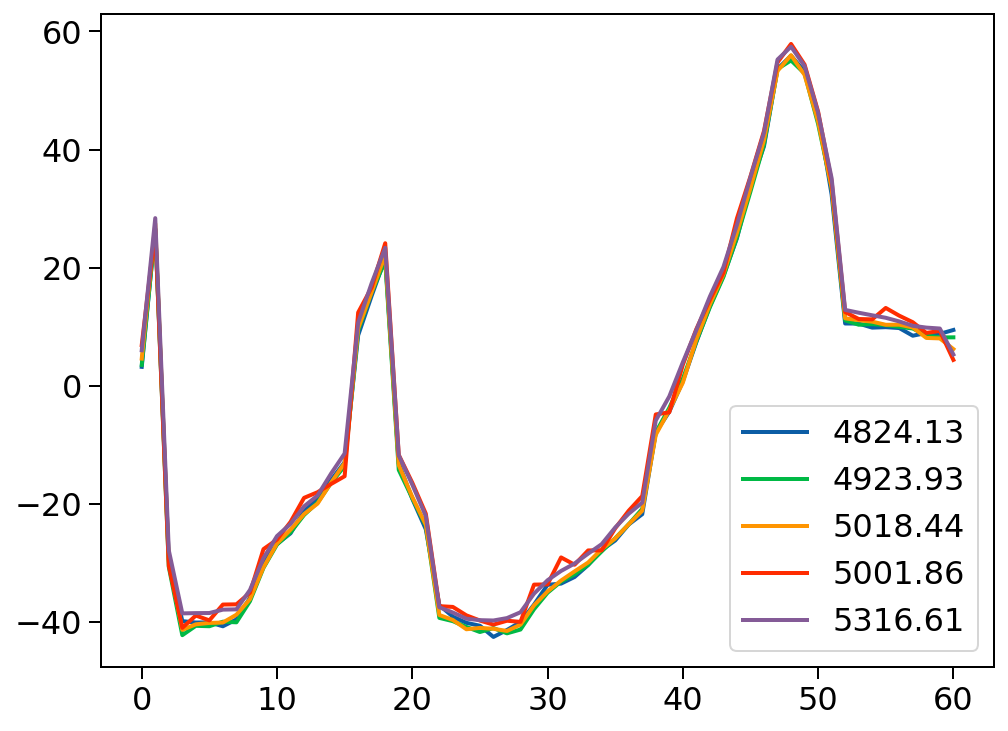

In [17]:
for i, j in zip(RV.T, lines):
    plt.plot(i, label=j)
plt.legend()

Text(0, 0.5, 'RV [km/s]')

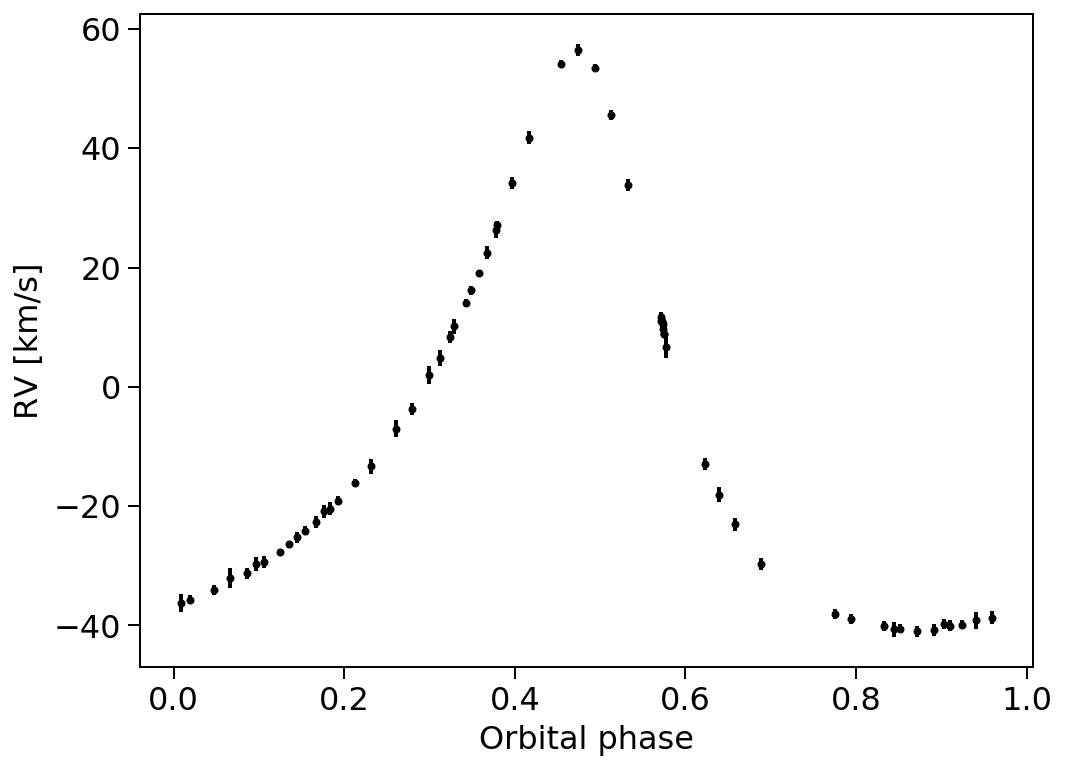

In [18]:
plt.errorbar((np.array(times)) % orbital_period / orbital_period, np.mean(total, axis=1), fmt='.k', yerr=RV_err)
# rv_time, rv_rv, rv_err = np.loadtxt('thuban/data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1,2)).T
# rv_time += 2457000
# plt.plot(rv_time % orbital_period / orbital_period, rv_rv - np.median(rv_rv), '.')
plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]')
# plt.xlim(0.55,0.6)
# plt.savefig('soda.png', dpi=300, bbox_inches='tight')

In [19]:
np.savetxt('data/RV/SONG.txt', list(zip(times, np.mean(total, axis=1), RV_err)))